## Profiler Code

In [1]:
%pip install --quiet pandas matplotlib psutil pynvml

Note: you may need to restart the kernel to use updated packages.


In [9]:

import time
import os
import pandas as pd
import threading
import psutil
from pynvml import *
from typing import List, Dict
import matplotlib.pyplot as plt

class ResourceMonitor:
    def __init__(self, interval=5, log_path=None, verbose=False):
        """
        Initialize the ResourceMonitor with optional log persistence.
        
        Args:
            interval (int): Time interval (in seconds) between resource checks
            log_path (str): Optional path to CSV file for saving/loading logs
            verbose: Whether to print events to console
        """
        self.interval = interval
        self.log_path = log_path
        self.verbose = verbose
        self.resource_log = []
        self.event_log = []
        self.monitoring = False
        self.thread = None
        
        self._log_event("SYSTEM", "ResourceMonitor initialized")
        # Load existing log if path is provided and file exists
        if self.log_path and os.path.exists(self.log_path):
            self.load_log(silent=True)

    def _log_gpu(self):
        """
        Log GPU usage using NVIDIA Management Library (NVML).
        
        Returns:
            dict: GPU memory usage and utilization. Returns zeros if no GPU is available.
        """
        try:
            nvmlInit()
            handle = nvmlDeviceGetHandleByIndex(0)
            mem_info = nvmlDeviceGetMemoryInfo(handle)
            util_info = nvmlDeviceGetUtilizationRates(handle)
            return {
                'gpu_mem_GB': mem_info.used / (1024 ** 3),
                'gpu_util_percent': util_info.gpu
            }
        except NVMLError as e:
            self._log_event("GPU", f"NVML error: {str(e)}. Possibly no Nvidia GPUs present in the system", is_error=True)
            return {
                'gpu_mem_GB': 0.0,
                'gpu_util_percent': 0.0
            }
        finally:
            try:
                nvmlShutdown()
            except:
                pass

    def _log_resources(self):
        """
        Log system resources (CPU, RAM, GPU) at regular intervals.
        """
        while self.monitoring:
            memory = psutil.virtual_memory().used / (1024 ** 3)  # RAM in GB
            cpu_percent = psutil.cpu_percent()
            gpu_stats = self._log_gpu()

            # Append resource usage to log
            self.resource_log.append({
                'timestamp': time.time(),
                'memory_GB': memory,
                'cpu_percent': cpu_percent,
                **gpu_stats
            })
            time.sleep(self.interval)

    def _log_event(self, category, message, is_error=False):
        """Internal method to log system events"""
        event = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "category": category,
            "message": message,
            "error": is_error
        }
        self.event_log.append(event)
        
        if self.verbose:
            status = "ERROR" if is_error else "INFO"
            print(f"[{event['timestamp']}] [{status}] {category}: {message}")


    def save_log(self, path: str = None) -> None:
        """Save metric logs to CSV"""
        try:
            save_path = path or self.log_path
            if not save_path:
                raise ValueError("No save path specified")
            
            # Ensure the directory exists
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            if os.path.exists(save_path):
                self._log_event("IO", f"File already exists: {save_path}. Overwriting.", is_error=False)
            
            df = self.get_logs()
            df.to_csv(save_path, index=False)
            self._log_event("IO", f"Saved {len(df)} entries to {save_path}")
            
        except Exception as e:
            self._log_event("ERROR", f"Save failed: {str(e)}", is_error=True)
            raise


    def load_log(self, path: str = None, silent: bool = False) -> None:
        """Load metric logs from CSV"""
        try:
            load_path = path or self.log_path
            if not load_path:
                raise ValueError("No load path specified")

            if os.path.exists(load_path):
                df = pd.read_csv(load_path, parse_dates=['timestamp'])
                self.resource_log = df.to_dict('records')
                msg = f"Loaded {len(df)} entries from {load_path}"
                self._log_event("IO", msg)
                if not silent:
                    print(msg)  # Always print load confirmation unless silent=True
            else:
                msg = f"File not found: {load_path}"
                self._log_event("IO", msg, is_error=True)
                if not silent:
                    print(msg)
                    
        except Exception as e:
            self._log_event("ERROR", f"Load failed: {str(e)}", is_error=True)
            raise


    def start(self, append_log=False):
        """
        Start resource monitoring.
        
        Args:
            append_log (bool): Whether to append to existing logs (False overwrites)
        """
        try:
            if self.monitoring:
                self._log_event("MONITOR", "Monitoring already in progress", is_error=True)
                raise RuntimeError("Monitoring already in progress")
            
            action = "Appending to" if append_log else "Starting new"
            self._log_event("MONITOR", f"{action} log session")

            if not append_log:
                self.resource_log.clear()
                self._log_event("DATA", "Existing logs cleared")

            self.monitoring = True
            self.thread = threading.Thread(target=self._log_resources, daemon=True)
            self.thread.start()
            self._log_event("THREAD", "Monitoring thread started")
        except Exception as e:
            self._log_event("ERROR", f"Start failed: {str(e)}", is_error=True)
            raise


    def stop(self) -> None:
        """Stop resource monitoring"""
        try:
            if self.monitoring:
                self.monitoring = False
                if self.thread is not None:
                    self.thread.join()
                    self._log_event("THREAD", "Monitoring thread stopped")
                self._log_event("MONITOR", "Stopped successfully")
            else:
                self._log_event("MONITOR", "Stop requested but not running", is_error=True)
                raise RuntimeError("Monitoring not running")
        except Exception as e:
            self._log_event("ERROR", f"Stop failed: {str(e)}", is_error=True)
            raise

    
    def get_event_log(self, filter_category: str = None) -> List[Dict]:
        """Retrieve event log with optional filtering"""
        if filter_category:
            return [e for e in self.event_log if e['category'] == filter_category]
        return self.event_log.copy()


    def get_last_event(self) -> Dict:
        """Get the most recent event"""
        return self.event_log[-1] if self.event_log else {}


    def print_event_log(self, max_events: int = 10) -> None:
        """Print recent events in readable format"""
        for event in self.event_log[-max_events:]:
            status = "ERROR" if event['error'] else "INFO"
            print(f"[{event['timestamp']}] [{status}] {event['category']}: {event['message']}")

    def get_logs(self):
        """
        Get the logged resource data as a pandas DataFrame.
        
        Returns:
            pd.DataFrame: Logged resource data.
        """
        df = pd.DataFrame(self.resource_log)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        return df

    def visualize_logs(self):
        """
        Visualize the logged resource data as time-series plots.
        """
        df = self.get_logs()

        if df.empty:
            print("No data to visualize.")
            return

        fig, ax = plt.subplots(3, 1, figsize=(12, 8))
        
        # Plot RAM usage
        df.plot(x='timestamp', y='memory_GB', ax=ax[0], title='RAM Usage (GB)', color='blue')
        
        # Plot CPU utilization
        df.plot(x='timestamp', y='cpu_percent', ax=ax[1], title='CPU Utilization (%)', color='orange')
        
        # Plot GPU memory usage and utilization
        df.plot(x='timestamp', y='gpu_mem_GB', ax=ax[2], title='GPU Memory Usage (GB)', color='green')
        
        plt.tight_layout()
        plt.show()

    def summarize_logs(self):
        """
        Summarize the logged resource data with key statistics.
        
        Returns:
            dict: Summary statistics of resource usage.
        """
        df = self.get_logs()
        
        if df.empty:
            print("No data to summarize.")
            return {}

        stats = {
            'Max RAM (GB)': df.memory_GB.max(),
            'Avg RAM (GB)': df.memory_GB.mean(),
            'Peak CPU (%)': df.cpu_percent.max(),
            'Max GPU Mem (GB)': df.gpu_mem_GB.max(),
            'Avg GPU Util (%)': df.gpu_util_percent.mean()
        }
        
        return stats

: 

## Load Dataset

In [4]:
%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets

from datasets import load_dataset
import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.2 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platfo

README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

#### View Dataset

In [10]:
# Display the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})


#### Sample Data

In [11]:
df = pd.DataFrame(dataset['train'])
df.head(10)

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,1,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,2,positive
7,50e14c0bb8,Soooo high,1,neutral
8,e050245fbd,Both of you,1,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,2,positive


## Load Model & Tokenizer

AutoTokenizer is a special class in the Huggingface Transformers library. It helps you choose the right tokenizer for your model without knowing the details.

Think of it as a smart assistant that knows which tool to use for the job.

The AutoTokenizer is easy to use. You don’t have to remember which tokenizer goes with which model. It ensures you use the correct tokenizer for the model, reducing errors and improving consistency.

Autotokenizer is flexible. It works with many different models, allowing you to switch models without changing much code.

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
token = hf_token

try:
    login(token=token)
    print("Logged in to Hugging Face Hub")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

HF_MODEL_NAME = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
print("Loaded Tokenizer")
base_model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME, num_labels=3)    
print("Loaded Model")


Logged in to Hugging Face Hub
Loaded Tokenizer


Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Model


#### Model Info

In [14]:
import json

def get_model_info(model):
    """Extract detailed information about the model."""
    model_info = {
        "Model Name": HF_MODEL_NAME,
        "Architecture": type(model).__name__,
        "Base Architecture": model.config.architectures[0] if hasattr(model.config, "architectures") else "N/A",
        "Model Type": model.config.model_type if hasattr(model.config, "model_type") else "N/A",
        "Number of Layers": len(list(model.model.layers)) if hasattr(model.model, "layers") else "N/A",
        "Total Parameters": sum(p.numel() for p in model.parameters()),
        "Trainable Parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "Non-Trainable Parameters": sum(p.numel() for p in model.parameters() if not p.requires_grad),  
        # some params like BatchNorm are not trainable; they are updated during training but not optimized using backpropagation. They are updated using mean and std calculations.
        "Device": next(model.parameters()).device,
    }

    # List all layers and their parameters
    layers_info = []
    for name, module in model.named_modules():  # Get all modules (i.e. layers in pytorch terminology) in the network: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
        layers_info.append({
            "Layer Name": name,
            "Layer Type": type(module).__name__,
            # module.parameters() returns an iterator over module parameters, which are the weights and biases of the layer (i.e. tensor). https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
            # p.numel() returns the total number of elements in the tensor (i.e. the number of parameters in the layer). https://pytorch.org/docs/stable/generated/torch.numel.html#torch.numel
            "Number of Parameters": sum(p.numel() for p in module.parameters()),
            "Trainable Parameters": sum(p.numel() for p in module.parameters() if p.requires_grad),
        })

    model_info["Layers"] = layers_info

    return model_info

# Get model information
model_info = get_model_info(base_model)

# Print model summary
print(f"Model Name: {model_info['Model Name']}")
print(f"Architecture: {model_info['Architecture']}")
print(f"Base Architecture: {model_info['Base Architecture']}")
print(f"Model Type: {model_info['Model Type']}")
print(f"Number of Layers: {model_info['Number of Layers']}")
print(f"Total Parameters: {model_info['Total Parameters']:,}")
print(f"Trainable Parameters: {model_info['Trainable Parameters']:,}")
print(f"Non-Trainable Parameters: {model_info['Non-Trainable Parameters']:,}")
print(f"Device: {model_info['Device']}")
print("\nLayers:")
for layer in model_info["Layers"]:
    print(f"  - {layer['Layer Name']} ({layer['Layer Type']}): {layer['Number of Parameters']:,} params")

# # Optional: Save the model info to a file
# with open("model_info.json", "w") as f:
#     json.dump(model_info, f, indent=4)

Model Name: Qwen/Qwen2.5-0.5B
Architecture: Qwen2ForSequenceClassification
Base Architecture: Qwen2ForCausalLM
Model Type: qwen2
Number of Layers: 24
Total Parameters: 494,035,456
Trainable Parameters: 494,035,456
Non-Trainable Parameters: 0
Device: cpu

Layers:
  -  (Qwen2ForSequenceClassification): 494,035,456 params
  - model (Qwen2Model): 494,032,768 params
  - model.embed_tokens (Embedding): 136,134,656 params
  - model.layers (ModuleList): 357,897,216 params
  - model.layers.0 (Qwen2DecoderLayer): 14,912,384 params
  - model.layers.0.self_attn (Qwen2SdpaAttention): 1,836,160 params
  - model.layers.0.self_attn.q_proj (Linear): 803,712 params
  - model.layers.0.self_attn.k_proj (Linear): 114,816 params
  - model.layers.0.self_attn.v_proj (Linear): 114,816 params
  - model.layers.0.self_attn.o_proj (Linear): 802,816 params
  - model.layers.0.self_attn.rotary_emb (Qwen2RotaryEmbedding): 0 params
  - model.layers.0.mlp (Qwen2MLP): 13,074,432 params
  - model.layers.0.mlp.gate_proj (L

#### View all special tokens

In [8]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

#### Tokenize Text (Split + Encode)

In [3]:
# Setting the pad token. By default, LLaMA models do not have a pad token, so we need to set it manually.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    # padding set make the batches equal to the value set in max_length 
    # truncation set to True to truncate the text if it exceeds max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

NameError: name 'dataset' is not defined

### Evaluate (function def only)

In [16]:
%pip install --quiet evaluate
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   return metric.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Fine Tune

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.000000,4.562196,0.590000
200,0.000000,4.637718,0.590000
300,0.000000,4.621735,0.590000
400,0.000000,4.613128,0.590000
500,0.000000,4.606270,0.590000
600,0.000000,4.600617,0.590000
700,0.000000,4.596299,0.590000
800,0.000000,4.593311,0.590000
900,0.000000,4.591869,0.590000
1000,0.000000,4.591550,0.590000


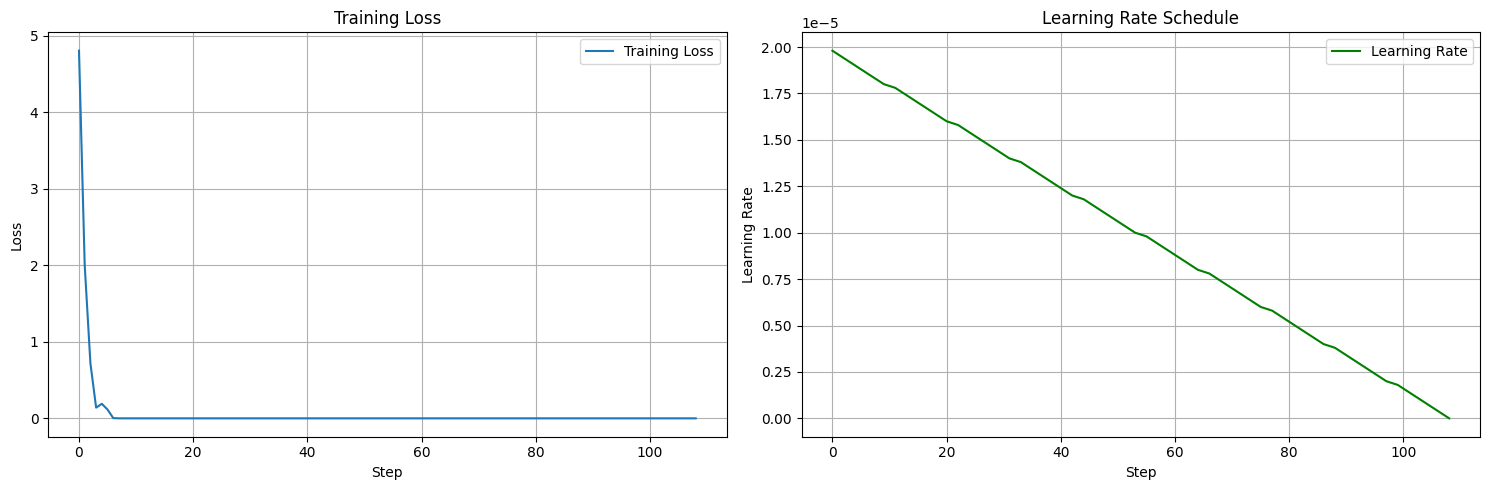

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Training completed.


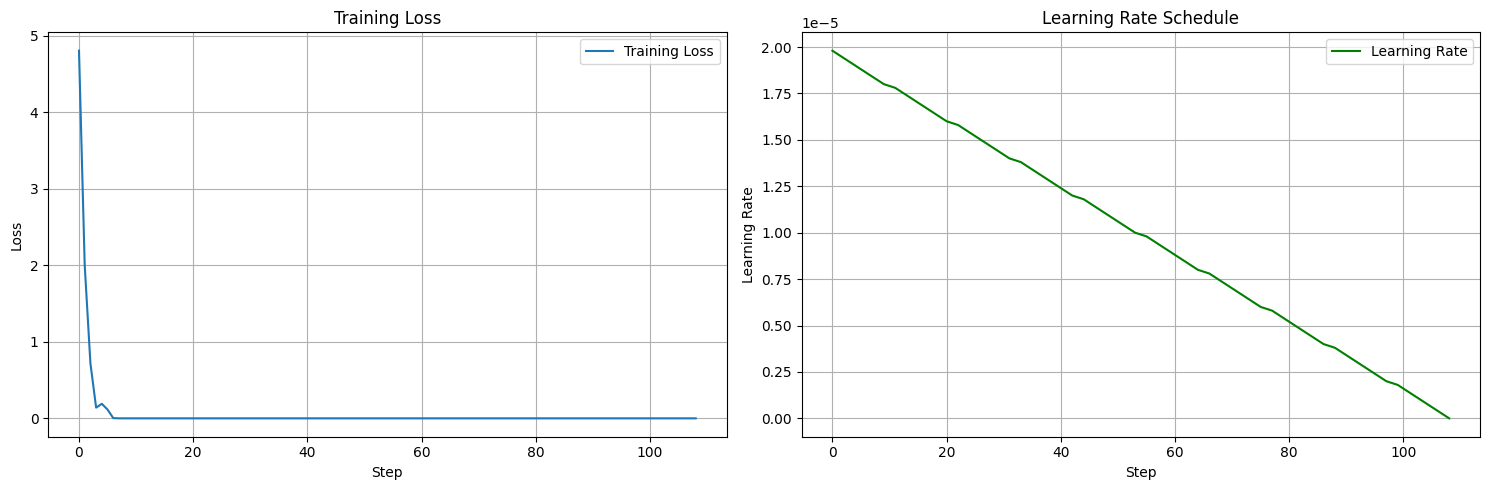

In [17]:
from transformers import TrainingArguments, Trainer, TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import display, update_display, HTML

class ProgressVisualizationCallback(TrainerCallback):
    def __init__(self):
        self.training_logs = []
        self.output_id = 'progress_viz'
        self.fig = None
    
    def on_train_begin(self, args, state, control, **kwargs):
        self.training_logs = []
        # Don't print anything here to avoid interfering with the default progress display
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            self.training_logs.append(logs)
            # Plot every 10 logs to avoid slowing down training
            if len(self.training_logs) % 10 == 0:
                self.visualize_progress(state)
    
    def visualize_progress(self, state):
        # Extract metrics
        steps = [log.get('step', i) for i, log in enumerate(self.training_logs) if 'loss' in log]
        loss = [log['loss'] for log in self.training_logs if 'loss' in log]
        lr = [log['learning_rate'] for log in self.training_logs if 'learning_rate' in log]
        
        # Create plot
        if self.fig is None:
            self.fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            display(self.fig, display_id=self.output_id)
        else:
            # Clear previous plot data
            for ax in self.fig.axes:
                ax.clear()
            ax1, ax2 = self.fig.axes
        
        # Loss plot
        ax1.plot(steps, loss, label='Training Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Learning rate plot
        ax2.plot(steps, lr, label='Learning Rate', color='green')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.legend()
        ax2.grid(True)
        
        self.fig.tight_layout()
        update_display(self.fig, display_id=self.output_id)
        
        # Don't print status here to avoid interfering with the default progress display

# Setup training with proper logging
training_args = TrainingArguments(
    output_dir="test_trainer",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="steps",
    eval_steps=100,    # Evaluate every 100 steps
    save_strategy="steps",
    save_steps=500,    # Save model every 100 steps
    save_only_model=True,  # Only save model weights, not optimizer state
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=1000,    # Set a specific number of steps
    report_to="none",  # Disable wandb/tensorboard to avoid conflicts
    learning_rate=2e-5,
    weight_decay=0.01,
)

# Create the trainer with our callback
progress_callback = ProgressVisualizationCallback()
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[progress_callback],  # Add the callback here
)

# Start training
print("Starting training...")
resource_monitor = ResourceMonitor(interval=60, log_path="training_log.csv", verbose=False)
resource_monitor.start(append_log=True)
trainer.train()
resource_monitor.stop()
print("Training completed.")

### Save Monitor Results

In [ ]:
from pprint import pprint

pprint(resource_monitor.summarize_logs())
resource_monitor.save_log("/kaggle/working/data.csv")
resource_monitor.visualize_logs()
# resource_monitor.summarize_logs()

{'Max RAM (GB)': 4.7707977294921875,
 'Avg RAM (GB)': 4.726389194356984,
 'Peak CPU (%)': 39.6,
 'Max GPU Mem (GB)': 12.4041748046875,
 'Avg GPU Util (%)': 95.17241379310344}

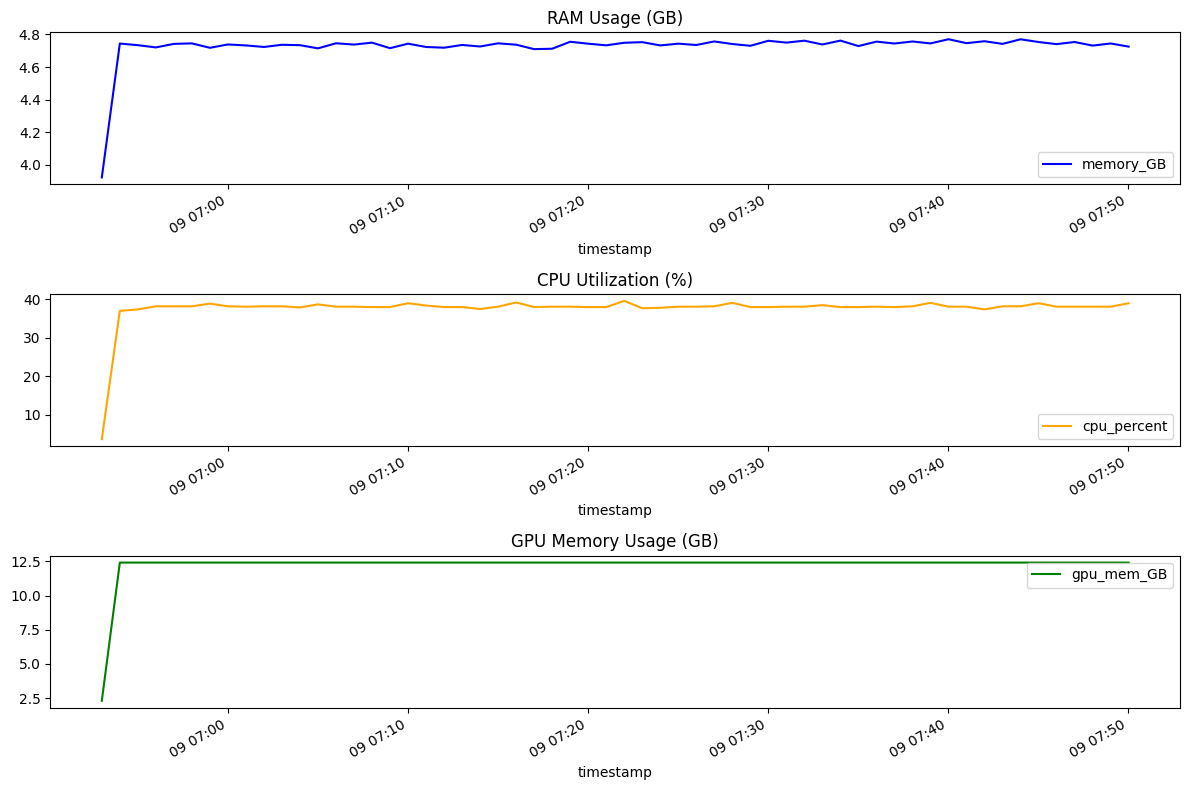

In [ ]:
# resource_monitor.save_log("/kaggle/working/data.csv")
# resource_monitor.visualize_logs()

### Saving the Model

In [8]:
import os

# Save in Hugging Face format
model_name = "llama-3.2-sentiment-classifier"
hf_dir = f"hf-{model_name}"
print(f"Saving model to {hf_dir}...")
# os.makedirs(hf_dir, exist_ok=True)

# 1. Save the model in Hugging Face format
trainer.save_model(hf_dir) 
print(f"✅ Model saved to {hf_dir}")

# Save tokenizer separately to ensure it's included
tokenizer.save_pretrained(hf_dir)
print(f"✅ Tokenizer saved to {hf_dir}")

# # To save to your local directory with a better structure
# model_name = "llama-3.2-sentiment-classifier"
# local_dir = f"{model_name}-{trainer.state.global_step}"
# trainer.save_model(local_dir)

# # 3. Convert to Ollama format
# print("Converting to Ollama format...")

# # Create Modelfile for Ollama
# ollama_dir = f"ollama-{model_name}"
# os.makedirs(ollama_dir, exist_ok=True)

# # Write Modelfile
# with open(f"{ollama_dir}/Modelfile", "w") as f:
#     f.write(f"""FROM llama3.2
# PARAMETER temperature 0.7
# PARAMETER top_p 0.9
# PARAMETER stop ["\n", "Human:", "Assistant:"]
# SYSTEM You are a sentiment analysis assistant specialized in analyzing tweets. Classify sentiment as positive, negative, or neutral.

# # Pull the model weights
# ADAPTER file=pytorch_model.bin

# LICENSE Apache 2.0
# """)

# # Copy necessary files from the HF format to Ollama format
# import shutil
# shutil.copy(f"{local_dir}/pytorch_model.bin", f"{ollama_dir}/pytorch_model.bin")
# shutil.copy(f"{local_dir}/config.json", f"{ollama_dir}/config.json")

# print(f"✅ Ollama files created in {ollama_dir}")
# print("To use with Ollama, run:")
# print(f"ollama create {model_name} -f {ollama_dir}/Modelfile")
# print(f"ollama run {model_name}")


Saving model to hf-llama-3.2-sentiment-classifier...
✅ Model saved to hf-llama-3.2-sentiment-classifier
✅ Tokenizer saved to hf-llama-3.2-sentiment-classifier


### Convert to Ollama (gguf)

In [10]:
# Install necessary libraries (run this in a separate cell if not already installed)
%pip install transformers safetensors huggingface_hub

# Clone llama.cpp repository and install its requirements
!git clone https://github.com/ggerganov/llama.cpp.git
%cd llama.cpp
%pip install -r requirements.txt
%cd ..

Note: you may need to restart the kernel to use updated packages.
Cloning into 'llama.cpp'...
remote: Enumerating objects: 47667, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 47667 (delta 96), reused 35 (delta 35), pack-reused 47513 (from 5)
Receiving objects: 100% (47667/47667), 99.69 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (34195/34195), done.
/kaggle/working/llama.cpp
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 6.1 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 M

In [12]:
import os

# List directories in the current working directory
directories = [d for d in os.listdir('.') if os.path.isdir(d)]
print("Directories:", directories)

Directories: ['llama.cpp', '.virtual_documents', 'hf-llama-3.2-sentiment-classifier', 'results']


In [20]:
import os
import subprocess

model_name = "llama-3.2-sentiment-classifier"
hf_dir = f"hf-{model_name}"
ollama_dir = f"ollama-{model_name}"
os.makedirs(ollama_dir, exist_ok=True)

# Define paths
output_gguf = "./model.gguf"      # Output GGUF file path
llama_cpp_dir = "./llama.cpp"    # Path to cloned llama.cpp directory
quantized_gguf = "./model_q4_k_m.gguf"  # Optional quantized GGUF file path

# Step 1: Verify that the saved model directory contains necessary files
required_files = [
    "config.json",
    "training_args.bin",
    "model.safetensors",
    "added_tokens.json",
    "merges.txt",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "vocab.json"
]  # Adjust based on your model
if not os.path.exists(hf_dir):
    raise FileNotFoundError(f"❌ Model directory {hf_dir} not found. Ensure trainer.save_model() ran successfully.")
missing_files = [file for file in required_files if not os.path.exists(os.path.join(hf_dir, file))]
if missing_files:
    raise FileNotFoundError(f"🔍 Missing files in {hf_dir}: {' | '.join(missing_files)}. Ensure all necessary files are present.")

# Step 2: Convert the Hugging Face model to GGUF using llama.cpp's convert_hf_to_gguf.py
convert_script = os.path.join(llama_cpp_dir, "convert_hf_to_gguf.py")
if not os.path.exists(convert_script):
    raise FileNotFoundError(f"❌ convert_hf_to_gguf.py not found in {llama_cpp_dir}. Ensure llama.cpp is cloned correctly.")

# # Method 1: Using ! for direct shell commands with variable interpolation
# print("\n\n=== Converting using ! command ===")
# !python {llama_cpp_dir}/convert_hf_to_gguf.py {hf_dir} --outfile {output_gguf} --verbose

# # # Check if conversion worked
# # print("\nChecking if output file was created:")
# # !ls -lh {output_gguf}

print("\n\n=== Alternative: Converting using %run ===")
%run {llama_cpp_dir}/convert_hf_to_gguf.py {hf_dir} --outfile {output_gguf}_alt --verbose
# Run the conversion command

convert_command = [
    "python",
    convert_script,
    hf_dir,              # Input directory from trainer.save_model()
    "--outfile", output_gguf  # Output GGUF file
]
result = subprocess.run(convert_command, capture_output=True, text=True)

# Check if conversion was successful
if result.returncode != 0:
    print("❌ Conversion failed!")
    print(result.stderr)
    print(result.stdout)
    print(result.returncode)
else:
    print("✅ Conversion successful!")
    print(f"GGUF file saved at: {output_gguf}")

# # Step 3 (Optional): Quantize the GGUF file (e.g., to Q4_K_M)
# quantize_script = os.path.join(llama_cpp_dir, "quantize")
# if os.path.exists(quantize_script) and os.path.exists(output_gguf):
#     quantize_command = [
#         quantize_script,
#         output_gguf,         # Input GGUF file
#         quantized_gguf,      # Output quantized GGUF file
#         "Q4_K_M"            # Quantization type (adjust as needed)
#     ]
#     quantize_result = subprocess.run(quantize_command, capture_output=True, text=True)
    
#     if quantize_result.returncode != 0:
#         print("Quantization failed!")
#         print(quantize_result.stderr)
#     else:
#         print("Quantization successful!")
#         print(f"Quantized GGUF file saved at: {quantized_gguf}")
# else:
#     print("Quantization script or GGUF file not found. Skipping quantization.")

# # Step 4: Verify the GGUF file exists
# if os.path.exists(output_gguf):
#     print(f"GGUF file is ready for use with Ollama: {output_gguf}")
# if os.path.exists(quantized_gguf):
#     print(f"Quantized GGUF file is ready for use with Ollama: {quantized_gguf}")



=== Alternative: Converting using %run ===
Traceback (most recent call last):
  File "/kaggle/working/llama.cpp/convert_hf_to_gguf.py", line 5486, in main
    model_class = Model.from_model_architecture(model_architecture)
  File "/kaggle/working/llama.cpp/convert_hf_to_gguf.py", line 492, in from_model_architecture
    raise NotImplementedError(f'Architecture {arch!r} not supported!') from None
NotImplementedError: Architecture 'Qwen2ForSequenceClassification' not supported!

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2831, in safe_execfile
    py3compat.execfile(
  File "/usr/local/lib/python3.10/dist-packages/IPython/utils/py3compat.py", line 168, in execfile
    exec(compiler(f.read(), fname, 'exec'), glob, loc)
  File "/kaggle/working/llama.cpp/convert_hf_to_gguf.py", line 5511, in <module>
    main()
  File "/kaggle/working/llama.c

TypeError: object of type 'NoneType' has no len()

In [28]:
!python ./llama.cpp/convert_hf_to_gguf.py hf-llama-3.2-sentiment-classifier --outfile model.gguf --verbose 

In [32]:
!find . -name "*.gguf" -type f

./llama.cpp/models/ggml-vocab-mpt.gguf
./llama.cpp/models/ggml-vocab-deepseek-llm.gguf
./llama.cpp/models/ggml-vocab-baichuan.gguf
./llama.cpp/models/ggml-vocab-command-r.gguf
./llama.cpp/models/ggml-vocab-llama-bpe.gguf
./llama.cpp/models/ggml-vocab-phi-3.gguf
./llama.cpp/models/ggml-vocab-starcoder.gguf
./llama.cpp/models/ggml-vocab-llama-spm.gguf
./llama.cpp/models/ggml-vocab-falcon.gguf
./llama.cpp/models/ggml-vocab-bert-bge.gguf
./llama.cpp/models/ggml-vocab-aquila.gguf
./llama.cpp/models/ggml-vocab-gpt-neox.gguf
./llama.cpp/models/ggml-vocab-qwen2.gguf
./llama.cpp/models/ggml-vocab-refact.gguf
./llama.cpp/models/ggml-vocab-gpt-2.gguf
./llama.cpp/models/ggml-vocab-deepseek-coder.gguf


In [22]:
%%bash
# This needs to be in its own cell to work properly
LLAMA_CPP_DIR="${llama_cpp_dir}"
HF_DIR="${hf_dir}"
OUTPUT="${output_gguf}_bash"

echo "Converting $HF_DIR to $OUTPUT..."
python $LLAMA_CPP_DIR/convert_hf_to_gguf.py $HF_DIR --outfile $OUTPUT --verbose

if [ -f "$OUTPUT" ]; then
    echo "✅ Conversion successful!"
    ls -lh $OUTPUT
else
    echo "❌ Conversion failed!"
fi


Converting  to _bash...
❌ Conversion failed!


python3: can't open file '/convert_hf_to_gguf.py': [Errno 2] No such file or directory


### Load model

In [2]:
# Load the fine-tuned model from saved files
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import json
from huggingface_hub import hf_hub_download
import torch

# Path to your saved model
model_path = "rtweera/tweet-finetuned-qwen2.5-0.5B"  # Update this to your saved model directory

print(f"Loading fine-tuned model from {model_path}...")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Check environment
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Try to download training_args from HuggingFace Hub first
try:
    args_file = hf_hub_download(repo_id=model_path, filename="training_args.bin")
    print(f"Downloaded training args from: {args_file}")
    
    # Load binary file with torch to CPU first, regardless of target device
    training_args = torch.load(args_file, map_location="cpu")
    print("✅ Successfully loaded training arguments from .bin file")
    
    # Just modify the no_cuda attribute based on current environment
    if device == "cpu":
        training_args.no_cuda = True
        print("Modified training args to disable CUDA (no_cuda=True)")
    else:
        training_args.no_cuda = False
        print("Modified training args to enable CUDA (no_cuda=False)")
    
    # Also update the output directory to a local path
    training_args.output_dir = "./results"
    
except Exception as e:
    print(f"Could not load training arguments: {e}")
    # Create default training args if original not available
    training_args = TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=8,
        no_cuda=(device == "cpu"),  # Set based on current environment
    )
    print("Created default training arguments")

# Now we can load the model with appropriate device settings
if device == "cpu":
    # For CPU, explicitly prevent any GPU usage
    fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
        model_path, device_map="cpu")
else:
    # For GPU, load normally
    fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(model_path)
    fine_tuned_model.to(device)

print(f"Model loaded successfully on {device}")

# Create a trainer for evaluation purposes
trainer = Trainer(
    model=fine_tuned_model,
    args=training_args,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Print some of the loaded training arguments to verify
print("\nLoaded Training Arguments:")
print(f"Output directory: {training_args.output_dir}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Evaluation strategy: {training_args.evaluation_strategy}")
print(f"no_cuda: {training_args.no_cuda}")
print(f"Current device: {device}")

# # Now you can evaluate the model
# print("\nEvaluating loaded model...")
# try:
#     eval_results = loaded_trainer.evaluate()
#     print(f"Evaluation results: {eval_results}")
# except Exception as e:
#     import traceback
#     print(f"Error during evaluation: {e}")
#     traceback.print_exc()

2025-04-10 10:12:30.544858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744279950.881316      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744279950.958278      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading fine-tuned model from rtweera/tweet-finetuned-qwen2.5-0.5B...


tokenizer_config.json:   0%|          | 0.00/7.26k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Using device: cuda


training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Downloaded training args from: /root/.cache/huggingface/hub/models--rtweera--tweet-finetuned-qwen2.5-0.5B/snapshots/41bf9107bc1684a42c1f63403a29721e84d7ed0e/training_args.bin
✅ Successfully loaded training arguments from .bin file
Modified training args to enable CUDA (no_cuda=False)


/tmp/ipykernel_71/636973245.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_args = torch.load(args_file, map_location="cpu")


config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Model loaded successfully on cuda


NameError: name 'small_eval_dataset' is not defined

In [19]:
# Load the model and perform inference only (no evaluation)
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from huggingface_hub import hf_hub_download

# Path to your saved model
model_path = "rtweera/tweet-finetuned-qwen2.5-0.5B"
print(f"Loading fine-tuned model from {model_path}...")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Determine device - use CPU if CUDA not available
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
except:
    device = "cpu"  # Fallback to CPU if checking CUDA fails
    
print(f"Using device: {device}")
model.to(device)
model.eval()  # Set model to evaluation mode

print(f"Model loaded successfully and moved to {device}")

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Function to predict sentiment for a single text
def predict_sentiment(text):
    """Predict sentiment for a single text input"""
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get prediction
    prediction = outputs.logits.argmax(-1).item()
    confidence_scores = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
    
    # Return sentiment and confidence scores
    return {
        "text": text,
        "sentiment": sentiment_labels[prediction],
        "sentiment_id": prediction,
        "confidence": {
            "negative": confidence_scores[0],
            "neutral": confidence_scores[1], 
            "positive": confidence_scores[2]
        }
    }

# Function to predict sentiment for multiple texts
def predict_batch_sentiment(texts, batch_size=8):
    """Predict sentiment for multiple texts in batches"""
    results = []
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get predictions
        predictions = outputs.logits.argmax(-1).tolist()
        confidence_scores = torch.nn.functional.softmax(outputs.logits, dim=-1).tolist()
        
        # Process results
        for j, (text, pred, conf) in enumerate(zip(batch_texts, predictions, confidence_scores)):
            results.append({
                "text": text,
                "sentiment": sentiment_labels[pred],
                "sentiment_id": pred,
                "confidence": {
                    "negative": conf[0],
                    "neutral": conf[1], 
                    "positive": conf[2]
                }
            })
    
    return results

# Example 1: Single text inference
print("\n=== Example 1: Single Text Inference ===")
test_text = "I absolutely love this product! Best purchase ever!"
result = predict_sentiment(test_text)

print(f"Text: '{result['text']}'")
print(f"Sentiment: {result['sentiment']}")
print(f"Confidence scores:")
for sentiment, score in result['confidence'].items():
    print(f"  - {sentiment}: {score:.4f}")

# Example 2: Multiple texts inference
print("\n=== Example 2: Multiple Texts Inference ===")
test_texts = [
    "I hate this, it's the worst thing ever.",
    "It's okay, nothing special but works fine.",
    "Great experience, would recommend to everyone!",
    "Terrible customer service, never again.",
    "This is just mediocre at best, wouldn't buy again."
]

# results = predict_batch_sentiment(test_texts)

# Display results in a more visual format
from IPython.display import display, Markdown, HTML
import pandas as pd

# # Convert results to DataFrame for better visualization
# df = pd.DataFrame([{
#     "Text": r["text"], 
#     "Sentiment": r["sentiment"],
#     "Negative": f"{r['confidence']['negative']:.4f}",
#     "Neutral": f"{r['confidence']['neutral']:.4f}",
#     "Positive": f"{r['confidence']['positive']:.4f}"
# } for r in results])

# Display as styled HTML table
# display(HTML(df.to_html(index=False)))

# Example 3: Interactive input (optional)
print("\n=== Example 3: Try Your Own Text ===")
print("Type a tweet to analyze its sentiment (or 'q' to quit):")

while True:
    user_input = input("> ")
    if user_input.lower() in ['q', 'quit', 'exit']:
        break
    
    if not user_input.strip():
        continue
        
    print(f"Tweet: {user_input}")
    result = predict_sentiment(user_input)
    print(f"Sentiment: {result['sentiment']}")
    
    # Show confidence with visual bar
    print("Confidence:")
    for sentiment, score in result['confidence'].items():
        bar = "▓" * int(score * 20)  # Create a visual bar with length proportional to confidence
        spaces = " " * (20 - len(bar))
        print(f"  {sentiment:8s} [{bar}{spaces}] {score:.4f}")
    
    print("\nType another tweet (or 'q' to quit):")

Loading fine-tuned model from rtweera/tweet-finetuned-qwen2.5-0.5B...
Using device: cpu
Model loaded successfully and moved to cpu

=== Example 1: Single Text Inference ===
Text: 'I absolutely love this product! Best purchase ever!'
Sentiment: Positive
Confidence scores:
  - negative: 0.0000
  - neutral: 0.0000
  - positive: 1.0000

=== Example 2: Multiple Texts Inference ===

=== Example 3: Try Your Own Text ===
Type a tweet to analyze its sentiment (or 'q' to quit):
Tweet: hi
Sentiment: Positive
Confidence:
  negative [▓                   ] 0.0738
  neutral  [                    ] 0.0001
  positive [▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓  ] 0.9261

Type another tweet (or 'q' to quit):
Tweet: yo yo
Sentiment: Neutral
Confidence:
  negative [                    ] 0.0000
  neutral  [▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ ] 0.9997
  positive [                    ] 0.0003

Type another tweet (or 'q' to quit):
Tweet: in 21:40, if I am not mistaken, the result from different heads are concatenated to a higher dimension matrix an

## NOT TESTED

# Test

In [18]:
import evaluate

trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

### View eval dataset

In [27]:
for k, v in small_eval_dataset[1].items():
    print(f"{k}: {v[:5]} ... {v[-5:]}") if isinstance(v, list) else print(f"{k}: {v}")

id: 2fac1b845b
text:  whatever do you mean?
label: 1
label_text: neutral
input_ids: [8820, 653, 498, 3076, 30] ... [151643, 151643, 151643, 151643, 151643]
attention_mask: [1, 1, 1, 1, 1] ... [0, 0, 0, 0, 0]



Evaluating base model with proper prompting...
Loading base LLM model...
Evaluating on 1000 examples


Evaluating Base Model (Zero-Shot):   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



=== Base Model (Zero-Shot) Evaluation Results (on 1000 examples) ===
Accuracy: 0.5750

Classification Report:
  Negative: Precision=0.6043, Recall=0.7908, F1=0.6851
  Neutral: Precision=0.6187, Recall=0.2098, F1=0.3133
  Positive: Precision=0.5407, Recall=0.8636, F1=0.6650


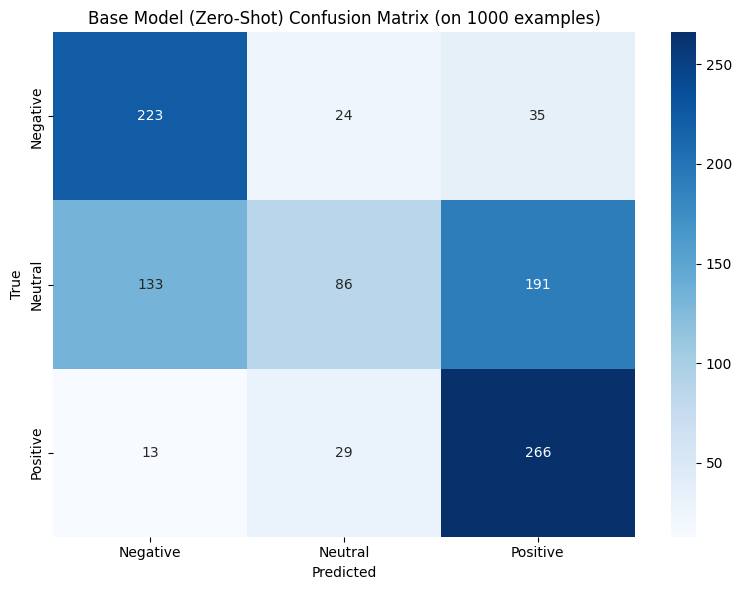

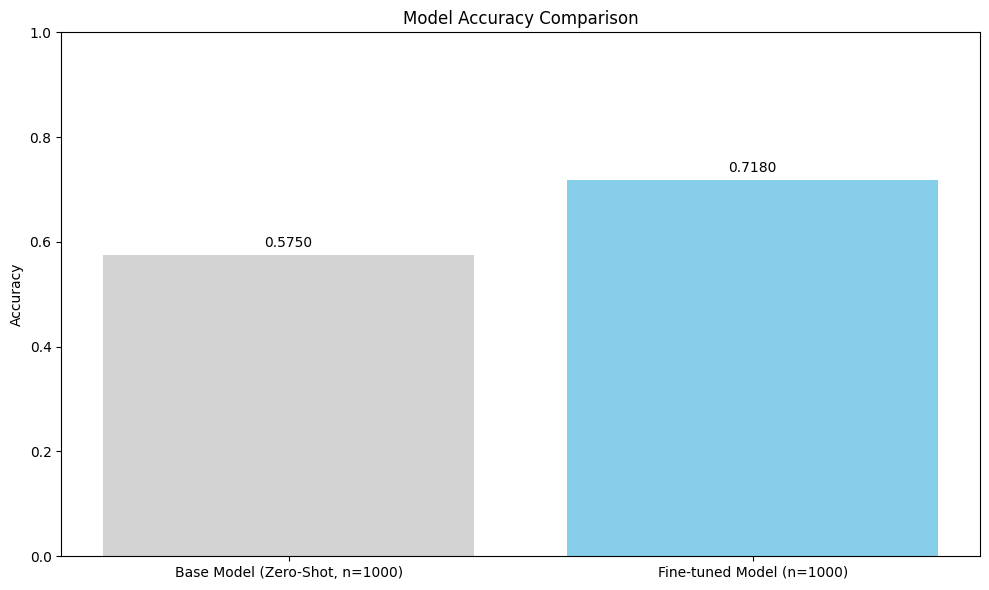


🔍 Performance Improvement: 14.30% absolute increase in accuracy

=== Example Predictions Comparison ===
Tweet: Why is looking for girls names easier than looking for boys
True label: Neutral
Base model response: "negative"
Base model prediction: Negative
Fine-tuned model prediction: Neutral
✓ Fine-tuned model prediction is correct
----------------------------------------------------------------------
Tweet: I`m a senior. I should of been already.
True label: Neutral
Base model response: "negative"
Base model prediction: Negative
Fine-tuned model prediction: Neutral
✓ Fine-tuned model prediction is correct
----------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Tweet:  ooh, work im afarid  looking forward to a sunny weekeknd tho!!!
True label: Negative
Base model response: "positive"
Base model prediction: Positive
Fine-tuned model prediction: Positive
----------------------------------------------------------------------
Tweet:  yep  but I`m going better now
True label: Positive
Base model response: "positive"
Base model prediction: Positive
Fine-tuned model prediction: Positive
✓ Base model prediction is correct
✓ Fine-tuned model prediction is correct
----------------------------------------------------------------------
Tweet: The Heater blew up
True label: Negative
Base model response: "negative"
Base model prediction: Negative
Fine-tuned model prediction: Neutral
✓ Base model prediction is correct
----------------------------------------------------------------------



## Model Comparison Summary

- Base Model (Zero-Shot) Accuracy: 0.5750
- Fine-tuned Model Accuracy: 0.7180
- Absolute Improvement: 14.30%
- Relative Improvement: 2486.96%

### Per-Class Improvements:

| Class | Base F1 | Fine-tuned F1 | Improvement |
|-------|---------|---------------|-------------|
| Negative | 0.6851 | 0.6940 | 0.89% |
| Neutral | 0.3133 | 0.7044 | 39.11% |
| Positive | 0.6650 | 0.7592 | 9.42% |


In [ ]:
# Add model comparison functionality
import torch
# 1. Function to evaluate a model on the validation dataset
def evaluate_model(model, tokenizer, eval_dataset, name="Model"):
    """Evaluate a model on the validation dataset and return metrics"""
    from tqdm.notebook import tqdm
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Process validation data in batches
    batch_size = 1  # adjust based on your GPU memory
    
    for i in tqdm(range(0, len(eval_dataset), batch_size), desc=f"Evaluating {name}"):
        batch = eval_dataset[i:i+batch_size]
        # Batch looks like: dict_keys(['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'])
        inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() 
                 if k in ['input_ids', 'attention_mask']}
        labels = torch.tensor(batch['label']).to(device) if 'label' in batch else None
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        
        all_preds.extend(predictions)
        if labels is not None:
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
    
    # Print results
    print(f"\n=== {name} Evaluation Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    for label, metrics in report.items():
        if label in ["Negative", "Neutral", "Positive"]:
            print(f"  {label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm,
        "predictions": all_preds,
        "labels": all_labels
    }

# Better base model evaluation with zero-shot prompting
def evaluate_base_model_with_prompting(tokenizer, eval_dataset, name="Base Model with Prompting", max_samples=None):
    """Evaluate base model using zero-shot prompting approach"""
    from tqdm.notebook import tqdm
    import torch
    from transformers import AutoModelForCausalLM
    import numpy as np
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Load full LLM model (not classification head)
    print("Loading base LLM model...")
    base_llm = AutoModelForCausalLM.from_pretrained(HF_MODEL_NAME)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    base_llm.to(device)
    base_llm.eval()
    
    all_preds = []
    all_labels = []
    
    # Define sentiment mapping
    sentiment_map = {
        "negative": 0,
        "neutral": 1, 
        "positive": 2
    }
    
    # Determine how many examples to evaluate
    num_examples = len(eval_dataset) if max_samples is None else min(max_samples, len(eval_dataset))
    print(f"Evaluating on {num_examples} examples")
    
    # Process validation data
    for i in tqdm(range(num_examples), desc=f"Evaluating {name}"):
        example = eval_dataset[i]
        text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
        true_label = example['label']
        
        # Create zero-shot prompt
        prompt = f"""Classify the sentiment of this tweet as either positive, negative, or neutral.
Tweet: "{text}"
Sentiment:"""

        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
        # Generate response with base model
        with torch.no_grad():
            outputs = base_llm.generate(
                inputs.input_ids,
                max_new_tokens=10,
                temperature=0.1,  # Low temperature for more deterministic output
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode response
        response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip().lower()
        
        # Get prediction based on response
        if "positive" in response:
            pred = 2
        elif "negative" in response:
            pred = 0
        elif "neutral" in response:
            pred = 1
        else:
            # Fallback for unclear responses - use most frequent word among sentiment options
            words = response.split()
            for word in words:
                if word in sentiment_map:
                    pred = sentiment_map[word]
                    break
            else:
                pred = 1  # Default to neutral if no sentiment word is found
        
        all_preds.append(pred)
        all_labels.append(true_label)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
    
    # Print results
    print(f"\n=== {name} Evaluation Results (on {num_examples} examples) ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    for label, metrics in report.items():
        if label in ["Negative", "Neutral", "Positive"]:
            print(f"  {label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix (on {num_examples} examples)')
    plt.tight_layout()
    plt.show()
    
    return {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm,
        "predictions": all_preds,
        "labels": all_labels,
        "num_examples": num_examples
    }

# Run the proper base model evaluation
print("\nEvaluating base model with proper prompting...")

# Set sample_size to adjust how many examples to use
# For quick testing, use a small number (100-200)
# For full evaluation (matching the fine-tuned model), use None or the full size
sample_size = None  # Use None to evaluate on all examples, same as fine-tuned model

base_metrics_proper = evaluate_base_model_with_prompting(
    tokenizer=tokenizer,
    eval_dataset=small_eval_dataset,
    name="Base Model (Zero-Shot)",
    max_samples=sample_size
)

# 3. Visualize the comparison
# Update the comparison - include sample size in the label
base_model_label = f'Base Model (Zero-Shot, n={base_metrics_proper["num_examples"]})'
finetuned_model_label = f'Fine-tuned Model (n={len(finetuned_metrics["predictions"])})'

labels = [base_model_label, finetuned_model_label]
accuracies = [base_metrics_proper['accuracy'], finetuned_metrics['accuracy']]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=['lightgray', 'skyblue'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate improvement
improvement = (finetuned_metrics['accuracy'] - base_metrics_proper['accuracy']) * 100
print(f"\n🔍 Performance Improvement: {improvement:.2f}% absolute increase in accuracy")

# 4. Example predictions comparison with zero-shot base model
print("\n=== Example Predictions Comparison ===")
# Sample 5 random examples from the validation set
import random
sample_indices = random.sample(range(len(small_eval_dataset)), 5)

# Keep reference to the base LLM model if it exists, otherwise load it
if 'base_llm' not in locals():
    print("Loading base LLM model for examples...")
    from transformers import AutoModelForCausalLM
    base_llm = AutoModelForCausalLM.from_pretrained(HF_MODEL_NAME)
    base_llm.to("cuda" if torch.cuda.is_available() else "cpu")
    base_llm.eval()

# Map numerical labels to text
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

for idx in sample_indices:
    example = small_eval_dataset[idx]
    text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    true_label = example['label']
    
    # Create prompt for base model
    prompt = f"""Classify the sentiment of this tweet as either positive, negative, or neutral.
Tweet: "{text}"
Sentiment:"""

    # Get prediction from base model using zero-shot prompting
    inputs = tokenizer(prompt, return_tensors="pt").to(base_llm.device)
    
    with torch.no_grad():
        outputs = base_llm.generate(
            inputs.input_ids,
            max_new_tokens=10,
            temperature=0.1,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode and interpret base model response
    base_response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip().lower()
    
    # Get base model prediction from response text
    if "positive" in base_response:
        base_pred = 2
    elif "negative" in base_response:
        base_pred = 0
    elif "neutral" in base_response:
        base_pred = 1
    else:
        # Default to neutral if unclear
        base_pred = 1
    
    # Get prediction from fine-tuned model
    ft_inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        ft_outputs = trainer.model(**{k: v.to(trainer.model.device) for k, v in ft_inputs.items()})
        ft_pred = torch.argmax(ft_outputs.logits, dim=-1).item()
    
    # Print comparison
    print(f"Tweet: {text}")
    print(f"True label: {label_map[true_label]}")
    print(f"Base model response: \"{base_response}\"")
    print(f"Base model prediction: {label_map[base_pred]}")
    print(f"Fine-tuned model prediction: {label_map[ft_pred]}")
    
    # Add a checkmark for correct predictions
    if base_pred == true_label:
        print("✓ Base model prediction is correct")
    if ft_pred == true_label:
        print("✓ Fine-tuned model prediction is correct")
    
    print("-" * 70)

# Display a final summary of improvements
improvement_summary = f"""
## Model Comparison Summary

- Base Model (Zero-Shot) Accuracy: {base_metrics_proper['accuracy']:.4f}
- Fine-tuned Model Accuracy: {finetuned_metrics['accuracy']:.4f}
- Absolute Improvement: {improvement:.2f}%
- Relative Improvement: {(improvement / base_metrics_proper['accuracy'] * 100):.2f}%

### Per-Class Improvements:

| Class | Base F1 | Fine-tuned F1 | Improvement |
|-------|---------|---------------|-------------|
"""

for label in ["Negative", "Neutral", "Positive"]:
    base_f1 = base_metrics_proper['classification_report'][label]['f1-score']
    ft_f1 = finetuned_metrics['classification_report'][label]['f1-score']
    class_improvement = (ft_f1 - base_f1) * 100
    improvement_summary += f"| {label} | {base_f1:.4f} | {ft_f1:.4f} | {class_improvement:.2f}% |\n"

from IPython.display import Markdown
display(Markdown(improvement_summary))